In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y_train, X_train, ids = load_csv_data(DATA_TRAIN_PATH)

In [6]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [8]:
from implementations import preprocess
tX_train, ty_train, tX_test, ty_test, cont_features = preprocess(X_train, y_train, X_test, imputable_th=0.3, encodable_min_th=0.3, encodable_max_th=0.7)

In [9]:
tX_train

array([[ 1.        ,  0.06833197,  0.40768027, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.55250482,  0.54013641, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  3.19515553,  1.09655998, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 1.        ,  0.31931645, -0.13086367, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.84532397, -0.30297338, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.66533608, -0.25352276, ...,  0.        ,
         0.        ,  0.        ]])

In [10]:
tX_train.shape, tX_test.shape

((250000, 24), (568238, 24))

In [35]:
from implementations import logistic_regression_cv
param_grid = {
    'lambda_': np.logspace(-4, 0, 5),
    'degree': list(range(1, 4)),
    'max_iters': 100,
    'cont_features': [cont_features]
}
weights, metrics, params = logistic_regression_cv(ty_train, tX_train, param_grid=param_grid)

Accuracy=71.828
Accuracy=70.63199999999999
Accuracy=72.114
Accuracy=71.172
Accuracy=70.562
Accuracy=75.90400000000001
Accuracy=75.166
Accuracy=77.28399999999999
Accuracy=75.614
Accuracy=77.064
Accuracy=71.922
Accuracy=73.678
Accuracy=76.214
Accuracy=75.42999999999999
Accuracy=73.024
Accuracy=71.846
Accuracy=70.638
Accuracy=72.134
Accuracy=71.182
Accuracy=70.594
Accuracy=75.94999999999999
Accuracy=75.21799999999999
Accuracy=77.3
Accuracy=75.664
Accuracy=77.084
Accuracy=71.93
Accuracy=72.684
Accuracy=76.25
Accuracy=75.51400000000001
Accuracy=74.274
Accuracy=72.028
Accuracy=70.842
Accuracy=72.36200000000001
Accuracy=71.398
Accuracy=70.794
Accuracy=76.356
Accuracy=75.71799999999999
Accuracy=77.718
Accuracy=76.042
Accuracy=77.248
Accuracy=75.11
Accuracy=73.91799999999999
Accuracy=76.36800000000001
Accuracy=75.77199999999999
Accuracy=74.698
Accuracy=71.72
Accuracy=71.334
Accuracy=71.8
Accuracy=71.65
Accuracy=71.296
Accuracy=76.146
Accuracy=75.952
Accuracy=76.582
Accuracy=75.83800000000001
Ac

In [37]:
params

{'lambda_': 0.01,
 'degree': 2,
 'max_iters': 100,
 'cont_features': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20]}

Iteration 0/1000
Accuracy = 34.322399999999995%
Loss = 5.817646820262799


Iteration 10/1000
Accuracy = 52.796%
Loss = 1.562288105956384


Iteration 20/1000
Accuracy = 62.1908%
Loss = 0.9133277554101196


Iteration 30/1000
Accuracy = 66.34%
Loss = 0.7413411065494199


Iteration 40/1000
Accuracy = 68.6472%
Loss = 0.6586529654155584


Iteration 50/1000
Accuracy = 70.6052%
Loss = 0.602033807153642


Iteration 60/1000
Accuracy = 72.2724%
Loss = 0.5632419896768377


Iteration 70/1000
Accuracy = 73.586%
Loss = 0.5365621899595447


Iteration 80/1000
Accuracy = 74.6692%
Loss = 0.5177877004996777


Iteration 90/1000
Accuracy = 75.5716%
Loss = 0.5043884068137361


Iteration 100/1000
Accuracy = 76.24600000000001%
Loss = 0.4947060358829992


Iteration 110/1000
Accuracy = 76.75319999999999%
Loss = 0.4876053860621903


Iteration 120/1000
Accuracy = 77.1572%
Loss = 0.4823343512015901


Iteration 130/1000
Accuracy = 77.4648%
Loss = 0.47839048264930734


Iteration 140/1000
Accuracy = 77.66999999999999%

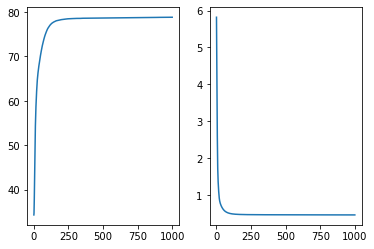

In [56]:
from implementations import reg_logistic_regression, build_poly
tX_train_poly = build_poly(tX_train, degree=2, cont_features=cont_features)
weights, loss = reg_logistic_regression(ty_train, tX_train_poly, max_iters=1000, lambda_=0.0001, verbose=True)

In [36]:
tX_test.shape

(568238, 24)

In [46]:
from implementations import build_poly
tX_test_poly = build_poly(tX_test, degree, cont_features)

In [47]:
tX_test_poly.shape

(568238, 42)

In [48]:
from datetime import datetime
from implementations import predict_log_reg
method = 'reg_logistic_regression'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'submissions/submission_{method}_{time}' # TODO: fill in desired name of output file for submission
y_pred = predict_log_reg(weights, tX_test_poly)
y_pred[np.where(y_pred == 0)] = -1
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)